# Vision Safari Dataset 점검 & 업로드

JSONL + 이미지를 로드하여 DataFrame으로 확인하고,
HuggingFace / Gemini fine-tuning 형식으로 업로드합니다.

### dataset.jsonl 스키마 (DataCollector 기준)
| 필드 | 설명 |
|---|---|
| `episode_id` | 에피소드 UUID (8자) |
| `mission` | 미션 텍스트 |
| `turn` | 턴 번호 (0-based) |
| `system_prompt` | 시스템 프롬프트 전문 |
| `context_text` | 턴별 컨텍스트 (위치, 메모장 등) |
| `image_file` | 스크린샷 상대 경로 (`images/ep_xxx_turn_000.png`) |
| `tool_calls` | `[{name, args}]` — 에이전트가 호출한 도구들 |
| `tool_results` | `[{name, result}]` — 도구 실행 결과 |
| `raw_request` | Gemini API 원본 요청 (systemInstruction, contents, tools, ...) |
| `raw_response` | Gemini API 원본 응답 (candidates, usageMetadata, ...)

In [16]:
import json
import pandas as pd
from pathlib import Path
from IPython.display import display

DATA_DIR = Path("../data/safari-dataset")
DATASET_FILE = DATA_DIR / "dataset.jsonl"

# Load JSONL
rows = []
with open(DATASET_FILE, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            rows.append(json.loads(line))

print(f"Loaded {len(rows)} turns from {DATASET_FILE}")
print(f"Episodes: {len(set(r['episode_id'] for r in rows))}")
print(f"Fields: {list(rows[0].keys()) if rows else '(empty)'}")

Loaded 11 turns from ..\data\safari-dataset\dataset.jsonl
Episodes: 2
Fields: ['episode_id', 'mission', 'turn', 'system_prompt', 'context_text', 'image_file', 'tool_calls', 'tool_results', 'raw_request', 'raw_response']


In [17]:
# DataFrame으로 전체 데이터 확인
df = pd.DataFrame([
    {
        "episode_id": r["episode_id"],
        "mission": r["mission"][:40] + "..." if len(r["mission"]) > 40 else r["mission"],
        "turn": r["turn"],
        "context_preview": r["context_text"][:60] + "..." if len(r["context_text"]) > 60 else r["context_text"],
        "image_file": r["image_file"],
        "image_exists": (DATA_DIR / r["image_file"]).exists(),
        "tool_calls": ", ".join(c["name"] for c in r.get("tool_calls", [])),
        "tool_results_count": len(r.get("tool_results", [])),
        "has_raw_request": r.get("raw_request") is not None,
        "has_raw_response": r.get("raw_response") is not None,
    }
    for r in rows
])

print(f"Shape: {df.shape}")
display(df)

# 에피소드별 요약
episode_summary = df.groupby("episode_id").agg(
    mission=("mission", "first"),
    turns=("turn", "count"),
    max_turn=("turn", "max"),
    images_ok=("image_exists", "sum"),
    has_raw=("has_raw_request", "sum"),
).reset_index()
print("\n에피소드별 요약:")
episode_summary

Shape: (11, 10)


,episode_id,mission,turn,context_preview,image_file,image_exists,tool_calls,tool_results_count,has_raw_request,has_raw_response
0,803bd562,파란배경 코라알 한테 가줘,0,Mission: 파란배경 코라알 한테 가줘\nStep: 1/180\nPosition...,images/ep_803bd562_turn_000.png,True,"update_notepad, move",2,True,True
1,803bd562,파란배경 코라알 한테 가줘,1,Mission: 파란배경 코라알 한테 가줘\nStep: 2/180\nPosition...,images/ep_803bd562_turn_001.png,True,"update_notepad, move",2,True,True
2,803bd562,파란배경 코라알 한테 가줘,2,Mission: 파란배경 코라알 한테 가줘\nStep: 3/180\nPosition...,images/ep_803bd562_turn_002.png,True,"move, update_notepad",2,True,True
3,803bd562,파란배경 코라알 한테 가줘,3,Mission: 파란배경 코라알 한테 가줘\nStep: 4/180\nPosition...,images/ep_803bd562_turn_003.png,True,"update_notepad, move",2,True,True
4,803bd562,파란배경 코라알 한테 가줘,4,Mission: 파란배경 코라알 한테 가줘\nStep: 5/180\nPosition...,images/ep_803bd562_turn_004.png,True,"update_notepad, move",2,True,True
5,803bd562,파란배경 코라알 한테 가줘,5,Mission: 파란배경 코라알 한테 가줘\nStep: 6/180\nPosition...,images/ep_803bd562_turn_005.png,True,"declare_found, update_notepad, declare_done",3,True,True
6,6445a779,빨간색 사자한테 가줘,0,Mission: 빨간색 사자한테 가줘\nStep: 1/180\nPosition: (...,images/ep_6445a779_turn_000.png,True,"update_notepad, move",2,True,True
7,6445a779,빨간색 사자한테 가줘,1,Mission: 빨간색 사자한테 가줘\nStep: 2/180\nPosition: (...,images/ep_6445a779_turn_001.png,True,"update_notepad, move",2,True,True
8,6445a779,빨간색 사자한테 가줘,2,Mission: 빨간색 사자한테 가줘\nStep: 3/180\nPosition: (...,images/ep_6445a779_turn_002.png,True,"move, update_notepad",2,True,True
9,6445a779,빨간색 사자한테 가줘,3,Mission: 빨간색 사자한테 가줘\nStep: 4/180\nPosition: (...,images/ep_6445a779_turn_003.png,True,"move, update_notepad",2,True,True



에피소드별 요약:


,episode_id,mission,turns,max_turn,images_ok,has_raw
0,6445a779,빨간색 사자한테 가줘,5,4,5,5
1,803bd562,파란배경 코라알 한테 가줘,6,5,6,6


Episode: 803bd562
Mission: 파란배경 코라알 한테 가줘
Turn: 0
Image: images/ep_803bd562_turn_000.png

--- Context Text ---
Mission: 파란배경 코라알 한테 가줘
Step: 1/180
Position: (26, 26)

Found Targets: (none)

Notepad:
(empty)

--- Tool Calls (2) ---
  update_notepad({"content": "[탐색 상태] 파란배경 코알라 발견. (27, 24)로 이동 중.\n[장애물/막힌 길] (25, 26), (27, 26), (26, 25), (27, 25))
  move({"actions": [{"steps": 1, "direction": "DOWN"}, {"steps": 2, "direction": "RIGHT"}, {"direction": "U)

--- Tool Results (2) ---
  update_notepad → {"status": "updated"}
  move → {"moved": true, "actualSteps": 1, "blocked": false, "pos": {"x": 27, "y": 24}, "onAnimal": {"emoji":

--- Raw Payload ---
  raw_request: ✅
  raw_response: ✅


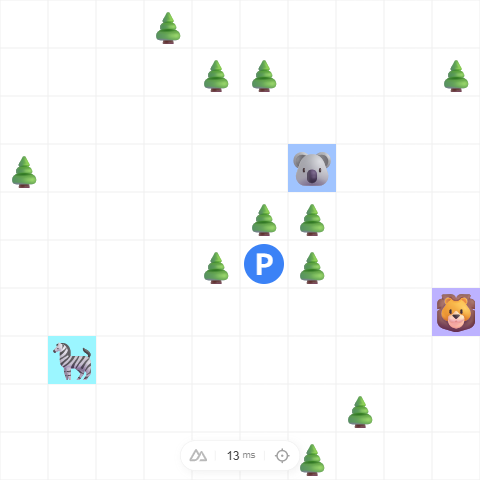

In [18]:
# 첫 번째 엔트리 상세 확인
if rows:
    r = rows[0]
    print(f"Episode: {r['episode_id']}")
    print(f"Mission: {r['mission']}")
    print(f"Turn: {r['turn']}")
    print(f"Image: {r['image_file']}")
    print(f"\n--- Context Text ---")
    print(r["context_text"])
    print(f"\n--- Tool Calls ({len(r.get('tool_calls', []))}) ---")
    for tc in r.get("tool_calls", []):
        print(f"  {tc['name']}({json.dumps(tc['args'], ensure_ascii=False)[:100]})")
    print(f"\n--- Tool Results ({len(r.get('tool_results', []))}) ---")
    for tr in r.get("tool_results", []):
        print(f"  {tr['name']} → {json.dumps(tr['result'], ensure_ascii=False)[:100]}")
    print(f"\n--- Raw Payload ---")
    print(f"  raw_request: {'✅' if r.get('raw_request') else '❌ (legacy)'}")
    print(f"  raw_response: {'✅' if r.get('raw_response') else '❌ (legacy)'}")

    # 이미지 미리보기
    from PIL import Image as PILImage
    img_path = DATA_DIR / r["image_file"]
    if img_path.exists():
        display(PILImage.open(img_path))

## Gemini Fine-Tuning 포맷 변환

각 턴을 Gemini API 네이티브 형식으로 변환합니다.

```
1턴 = systemInstruction + contents[0] user(text+image) + contents[1] model(functionCall) + contents[2] user(functionResponse) + tools
```

In [19]:
import base64

# Tool declarations (Gemini native format) — tools.ts 기준
TOOL_DECLARATIONS = [{
    "functionDeclarations": [
        {
            "name": "move",
            "description": "플레이어를 이동시킨다. 최대 4개 행동을 순서대로 실행하며, 각 행동은 방향(UP/DOWN/LEFT/RIGHT)과 칸수(1~3)를 가진다.",
            "parameters": {
                "type": "OBJECT",
                "properties": {
                    "actions": {
                        "type": "ARRAY",
                        "items": {
                            "type": "OBJECT",
                            "properties": {
                                "direction": {"type": "STRING", "enum": ["UP", "DOWN", "LEFT", "RIGHT"]},
                                "steps": {"type": "INTEGER"}
                            },
                            "required": ["direction", "steps"]
                        }
                    }
                },
                "required": ["actions"]
            }
        },
        {
            "name": "update_notepad",
            "description": "메모장 전체를 덮어쓴다. 유지할 내용도 포함해서 작성해야 한다. 최대 2000자.",
            "parameters": {
                "type": "OBJECT",
                "properties": {"content": {"type": "STRING"}},
                "required": ["content"]
            }
        },
        {
            "name": "declare_found",
            "description": "특정 타겟을 찾아서 도달했음을 선언한다.",
            "parameters": {
                "type": "OBJECT",
                "properties": {"target": {"type": "STRING"}},
                "required": ["target"]
            }
        },
        {
            "name": "declare_done",
            "description": "전체 미션이 완료되었음을 선언한다.",
            "parameters": {
                "type": "OBJECT",
                "properties": {"reason": {"type": "STRING"}},
                "required": []
            }
        }
    ]
}]


def convert_single_turn(entry, data_dir):
    """단일 턴을 Gemini fine-tuning 포맷으로 변환"""

    # --- raw_request가 있는 경우: 거의 그대로 사용 ---
    if entry.get("raw_request"):
        req = entry["raw_request"]
        res = entry.get("raw_response", {})

        contents = list(req.get("contents", []))

        # Model turn (from response)
        candidates = res.get("raw", {}).get("candidates", [])
        if candidates and candidates[0].get("content"):
            contents.append(candidates[0]["content"])

        # Function response turn
        if entry.get("tool_results"):
            contents.append({
                "role": "user",
                "parts": [
                    {"functionResponse": {"name": tr["name"], "response": tr["result"]}}
                    for tr in entry["tool_results"]
                ]
            })

        return {
            "systemInstruction": req.get("systemInstruction"),
            "contents": contents,
            "tools": req.get("tools", TOOL_DECLARATIONS),
        }

    # --- legacy 데이터: 수동 변환 ---
    # User turn
    user_parts = [{"text": entry["context_text"]}]
    img_path = data_dir / entry["image_file"]
    if img_path.exists():
        img_b64 = base64.b64encode(img_path.read_bytes()).decode()
        user_parts.append({"inlineData": {"mimeType": "image/png", "data": img_b64}})

    contents = [{"role": "user", "parts": user_parts}]

    # Model turn (functionCalls)
    if entry.get("tool_calls"):
        contents.append({
            "role": "model",
            "parts": [
                {"functionCall": {"name": tc["name"], "args": tc["args"]}}
                for tc in entry["tool_calls"]
            ]
        })

    # Function response turn
    if entry.get("tool_results"):
        contents.append({
            "role": "user",
            "parts": [
                {"functionResponse": {"name": tr["name"], "response": tr["result"]}}
                for tr in entry["tool_results"]
            ]
        })

    return {
        "systemInstruction": {"role": "user", "parts": [{"text": entry["system_prompt"]}]},
        "contents": contents,
        "tools": TOOL_DECLARATIONS,
    }


# 변환 실행
gemini_examples = [convert_single_turn(r, DATA_DIR) for r in rows]
print(f"Converted {len(gemini_examples)} examples")

# 변환 결과 검증
for i, ex in enumerate(gemini_examples):
    n_contents = len(ex.get("contents", []))
    has_sys = ex.get("systemInstruction") is not None
    has_tools = len(ex.get("tools", [])) > 0
    roles = [c.get("role", "?") for c in ex.get("contents", [])]
    print(f"  [{i}] systemInstruction={'✅' if has_sys else '❌'} | contents={n_contents} {roles} | tools={'✅' if has_tools else '❌'}")

Converted 11 examples
  [0] systemInstruction=✅ | contents=3 ['user', 'model', 'user'] | tools=✅
  [1] systemInstruction=✅ | contents=3 ['user', 'model', 'user'] | tools=✅
  [2] systemInstruction=✅ | contents=3 ['user', 'model', 'user'] | tools=✅
  [3] systemInstruction=✅ | contents=3 ['user', 'model', 'user'] | tools=✅
  [4] systemInstruction=✅ | contents=3 ['user', 'model', 'user'] | tools=✅
  [5] systemInstruction=✅ | contents=3 ['user', 'model', 'user'] | tools=✅
  [6] systemInstruction=✅ | contents=3 ['user', 'model', 'user'] | tools=✅
  [7] systemInstruction=✅ | contents=3 ['user', 'model', 'user'] | tools=✅
  [8] systemInstruction=✅ | contents=3 ['user', 'model', 'user'] | tools=✅
  [9] systemInstruction=✅ | contents=3 ['user', 'model', 'user'] | tools=✅
  [10] systemInstruction=✅ | contents=3 ['user', 'model', 'user'] | tools=✅


In [20]:
# 변환된 첫 번째 example 구조 미리보기 (base64 이미지는 축약)
if gemini_examples:
    ex = gemini_examples[0]

    def truncate_base64(obj):
        """base64 data를 축약해서 보기 편하게"""
        if isinstance(obj, dict):
            result = {}
            for k, v in obj.items():
                if k == "data" and isinstance(v, str) and len(v) > 100:
                    result[k] = f"<base64 {len(v)} chars>"
                else:
                    result[k] = truncate_base64(v)
            return result
        elif isinstance(obj, list):
            return [truncate_base64(item) for item in obj]
        return obj

    preview = truncate_base64(ex)
    print(json.dumps(preview, indent=2, ensure_ascii=False))

{
  "systemInstruction": {
    "role": "system",
    "parts": [
      {
        "text": "너는 'Vision Safari' 게임의 AI 에이전트야.\n50x50 그리드를 탐색하지만, 플레이어 주변 10x10 영역만 볼 수 있어.\n\n그리드에서 보이는 것들:\n- 'P' (파란 원) = 플레이어 (너)\n- '🌲' = 나무 (장애물, 통과 불가)\n- 색깔 배경 위의 동물 이모지 = 타겟\n\n매 턴마다 현재 10x10 시야가 이미지로 자동 제공돼. 직접 캡처할 필요 없어.\n\n필수 규칙:\n- 한 턴에 여러 도구를 동시에 호출할 수 있다. 예: Move + UpdateNotepad를 함께 호출.\n- 제공된 시야 이미지를 분석한 후 다음 행동을 결정해.\n- Move 결과에 \"on_animal\"이 포함되면, 타겟과 일치하는지 확인하고 다음 턴에 DeclareFound를 호출해.\n- 모든 타겟을 찾은 후 DeclareDone을 호출해.\n- 이동이 막혔으면(actual_steps < 요청한 수) 다른 방향을 시도해.\n\n멀티 미션 워크플로우:\n- 여러 타겟을 찾아야 할 수 있어 (예: \"빨간 호랑이와 분홍 기린을 찾아\").\n- 타겟을 찾을 때마다: DeclareFound를 호출해 (예: \"빨간배경 호랑이\").\n- 모든 타겟을 찾은 후: DeclareDone을 호출해서 미션을 종료해.\n- 메모리 컨텍스트의 \"찾은 타겟\" 항목을 확인해서 이미 찾은 타겟을 파악해.\n\n메모장 프로토콜:\n- 덮어쓰기 방식이므로 유지할 내용도 반드시 포함해서 작성해. 빠뜨리면 사라져!\n- 메모장은 미션 간에도 영구 보존돼. 이전 미션에서 기록한 맵 정보를 다음 미션에서 활용할 수 있어.\n- Move와 함께 호출하면 효율적이다. 이동하면서 동시에 관찰 내용을 기록할 수 있어.\n- 기록할 내용 템플릿:\n  [탐색 상태] 현재 탐색 방향, 다음 계획\n  [장애물/막힌 길] 나무 위치

## Gemini Fine-Tuning JSONL 저장

In [21]:
# dataset-gemini.jsonl 저장
GEMINI_FILE = DATA_DIR / "dataset-gemini.jsonl"

with open(GEMINI_FILE, "w", encoding="utf-8") as f:
    for ex in gemini_examples:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

file_size_mb = GEMINI_FILE.stat().st_size / (1024 * 1024)
print(f"Saved {len(gemini_examples)} examples to {GEMINI_FILE}")
print(f"File size: {file_size_mb:.2f} MB")

Saved 11 examples to ..\data\safari-dataset\dataset-gemini.jsonl
File size: 0.42 MB


## Qwen3-VL Fine-Tuning 포맷 변환

Gemini의 raw_response에서 **thought 파트**를 추출하여 Qwen3-VL의 assistant content로 매핑합니다.

### 매핑 구조
| Gemini | Qwen3-VL |
|---|---|
| `systemInstruction` | `{"role": "system", "content": ...}` |
| `contents[0]` (user + image) | `{"role": "user", "content": [image, text]}` |
| `thought` 파트 (candidates) | assistant `content` (사고 과정) |
| `functionCall` 파트 (candidates) | assistant `tool_calls` |
| `functionResponse` | `{"role": "tool", ...}` |
| Gemini `functionDeclarations` | OpenAI-style `tools` |



In [22]:
# Qwen3-VL tool definitions (OpenAI format) — Gemini functionDeclarations에서 변환
QWEN3_TOOLS = [
    {
        "type": "function",
        "function": {
            "name": "move",
            "description": "플레이어를 이동시킨다. 최대 4개 행동을 순서대로 실행하며, 각 행동은 방향(UP/DOWN/LEFT/RIGHT)과 칸수(1~3)를 가진다.",
            "parameters": {
                "type": "object",
                "properties": {
                    "actions": {
                        "type": "array",
                        "items": {
                            "type": "object",
                            "properties": {
                                "direction": {"type": "string", "enum": ["UP", "DOWN", "LEFT", "RIGHT"]},
                                "steps": {"type": "integer"}
                            },
                            "required": ["direction", "steps"]
                        }
                    }
                },
                "required": ["actions"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "update_notepad",
            "description": "메모장 전체를 덮어쓴다. 유지할 내용도 포함해서 작성해야 한다. 최대 2000자.",
            "parameters": {
                "type": "object",
                "properties": {"content": {"type": "string"}},
                "required": ["content"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "declare_found",
            "description": "특정 타겟을 찾아서 도달했음을 선언한다.",
            "parameters": {
                "type": "object",
                "properties": {"target": {"type": "string"}},
                "required": ["target"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "declare_done",
            "description": "전체 미션이 완료되었음을 선언한다.",
            "parameters": {
                "type": "object",
                "properties": {"reason": {"type": "string"}},
                "required": []
            }
        }
    }
]


def extract_thought(raw_response):
    """raw_response에서 Gemini thought 파트 추출"""
    if not raw_response:
        return None
    parts = raw_response.get("raw", {}).get("candidates", [{}])[0].get("content", {}).get("parts", [])
    thoughts = [p["text"] for p in parts if p.get("thought") == True]
    return "\n".join(thoughts) if thoughts else None


def convert_to_qwen3(entry):
    """단일 턴을 Qwen3-VL fine-tuning 포맷으로 변환"""
    thought = extract_thought(entry.get("raw_response"))

    # System message
    messages = [
        {"role": "system", "content": entry["system_prompt"]},
    ]

    # User message (image + text)
    messages.append({
        "role": "user",
        "content": [
            {"type": "image", "image": f"data/safari-dataset/{entry['image_file']}"},
            {"type": "text", "text": entry["context_text"]},
        ]
    })

    # Assistant message (thought + tool_calls)
    assistant_msg = {
        "role": "assistant",
        "content": thought,
        "tool_calls": [
            {
                "type": "function",
                "function": {
                    "name": tc["name"],
                    "arguments": json.dumps(tc["args"], ensure_ascii=False),
                }
            }
            for tc in entry.get("tool_calls", [])
        ],
    }
    messages.append(assistant_msg)

    # Tool results
    for tr in entry.get("tool_results", []):
        messages.append({
            "role": "tool",
            "name": tr["name"],
            "content": json.dumps(tr["result"], ensure_ascii=False),
        })

    return {"messages": messages, "tools": QWEN3_TOOLS}


# 변환 실행
qwen3_examples = [convert_to_qwen3(r) for r in rows]
print(f"Converted {len(qwen3_examples)} examples to Qwen3-VL format")

# 변환 결과 검증
for i, ex in enumerate(qwen3_examples):
    msgs = ex["messages"]
    roles = [m["role"] for m in msgs]
    has_thought = msgs[2]["content"] is not None if len(msgs) > 2 else False
    n_tool_calls = len(msgs[2].get("tool_calls", [])) if len(msgs) > 2 else 0
    n_tool_results = sum(1 for m in msgs if m["role"] == "tool")
    print(f"  [{i}] roles={roles} | thought={'✅' if has_thought else '❌'} | tool_calls={n_tool_calls} | tool_results={n_tool_results}")

Converted 11 examples to Qwen3-VL format
  [0] roles=['system', 'user', 'assistant', 'tool', 'tool'] | thought=❌ | tool_calls=2 | tool_results=2
  [1] roles=['system', 'user', 'assistant', 'tool', 'tool'] | thought=❌ | tool_calls=2 | tool_results=2
  [2] roles=['system', 'user', 'assistant', 'tool', 'tool'] | thought=❌ | tool_calls=2 | tool_results=2
  [3] roles=['system', 'user', 'assistant', 'tool', 'tool'] | thought=❌ | tool_calls=2 | tool_results=2
  [4] roles=['system', 'user', 'assistant', 'tool', 'tool'] | thought=❌ | tool_calls=2 | tool_results=2
  [5] roles=['system', 'user', 'assistant', 'tool', 'tool', 'tool'] | thought=❌ | tool_calls=3 | tool_results=3
  [6] roles=['system', 'user', 'assistant', 'tool', 'tool'] | thought=✅ | tool_calls=2 | tool_results=2
  [7] roles=['system', 'user', 'assistant', 'tool', 'tool'] | thought=✅ | tool_calls=2 | tool_results=2
  [8] roles=['system', 'user', 'assistant', 'tool', 'tool'] | thought=✅ | tool_calls=2 | tool_results=2
  [9] roles=['s

In [23]:
# 변환된 첫 번째 Qwen3-VL example 미리보기
if qwen3_examples:
    ex = qwen3_examples[0]
    preview = {
        "messages": [
            {**m, "content": m["content"][:200] + "..." if isinstance(m["content"], str) and len(m["content"]) > 200 else m["content"]}
            for m in ex["messages"]
        ],
        "tools": f"<{len(ex['tools'])} tools>",
    }
    print(json.dumps(preview, indent=2, ensure_ascii=False))

{
  "messages": [
    {
      "role": "system",
      "content": "너는 'Vision Safari' 게임의 AI 에이전트야.\n50x50 그리드를 탐색하지만, 플레이어 주변 10x10 영역만 볼 수 있어.\n\n그리드에서 보이는 것들:\n- 'P' (파란 원) = 플레이어 (너)\n- '🌲' = 나무 (장애물, 통과 불가)\n- 색깔 배경 위의 동물 이모지 = 타겟\n\n매 턴마다 현재 10x10 시야가 이미지로 자동 제공돼. 직접 캡..."
    },
    {
      "role": "user",
      "content": [
        {
          "type": "image",
          "image": "data/safari-dataset/images/ep_803bd562_turn_000.png"
        },
        {
          "type": "text",
          "text": "Mission: 파란배경 코라알 한테 가줘\nStep: 1/180\nPosition: (26, 26)\n\nFound Targets: (none)\n\nNotepad:\n(empty)"
        }
      ]
    },
    {
      "role": "assistant",
      "content": null,
      "tool_calls": [
        {
          "type": "function",
          "function": {
            "name": "update_notepad",
            "arguments": "{\"content\": \"[탐색 상태] 파란배경 코알라 발견. (27, 24)로 이동 중.\\n[장애물/막힌 길] (25, 26), (27, 26), (26, 25), (27, 25) 나무로 둘러싸임. 아래로 우회 필요.\\n[동물 목격] \\n- 코알라(파란 배경): (27

In [24]:
# dataset-qwen3.jsonl 저장
QWEN3_FILE = DATA_DIR / "dataset-qwen3.jsonl"

with open(QWEN3_FILE, "w", encoding="utf-8") as f:
    for ex in qwen3_examples:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

file_size_mb = QWEN3_FILE.stat().st_size / (1024 * 1024)
print(f"Saved {len(qwen3_examples)} examples to {QWEN3_FILE}")
print(f"File size: {file_size_mb:.2f} MB")

# Thought 통계
n_with_thought = sum(1 for r in rows if extract_thought(r.get("raw_response")) is not None)
print(f"\nThought 포함 턴: {n_with_thought}/{len(rows)} ({n_with_thought/len(rows)*100:.0f}%)")

Saved 11 examples to ..\data\safari-dataset\dataset-qwen3.jsonl
File size: 0.07 MB

Thought 포함 턴: 5/11 (45%)


## 업로드

### Option A: HuggingFace Hub
원본 데이터셋 (이미지 포함)을 HuggingFace에 업로드

### Option B: Gemini Fine-Tuning API
변환된 JSONL을 Gemini tuning API에 직접 업로드

In [30]:
# Option A: HuggingFace Hub 업로드
# pip install datasets huggingface_hub 필요
# huggingface-cli login 으로 먼저 인증

from datasets import Dataset, Image as HFImage
from huggingface_hub import login

records = []
for r in rows:
    img_path = DATA_DIR / r["image_file"]
    records.append({
        "episode_id": r["episode_id"],
        "mission": r["mission"],
        "turn": r["turn"],
        "system_prompt": r["system_prompt"],
        "context_text": r["context_text"],
        "image": str(img_path) if img_path.exists() else None,
        "tool_calls": json.dumps(r.get("tool_calls", []), ensure_ascii=False),
        "tool_results": json.dumps(r.get("tool_results", []), ensure_ascii=False),
        "has_raw": r.get("raw_request") is not None,
    })

ds = Dataset.from_list(records)
ds = ds.cast_column("image", HFImage())
print(ds)
print("\nSample:")
print(ds[0])

Dataset({
    features: ['episode_id', 'mission', 'turn', 'system_prompt', 'context_text', 'image', 'tool_calls', 'tool_results', 'has_raw'],
    num_rows: 11
})

Sample:
{'episode_id': '803bd562', 'mission': '파란배경 코라알 한테 가줘', 'turn': 0, 'system_prompt': '너는 \'Vision Safari\' 게임의 AI 에이전트야.\n50x50 그리드를 탐색하지만, 플레이어 주변 10x10 영역만 볼 수 있어.\n\n그리드에서 보이는 것들:\n- \'P\' (파란 원) = 플레이어 (너)\n- \'🌲\' = 나무 (장애물, 통과 불가)\n- 색깔 배경 위의 동물 이모지 = 타겟\n\n매 턴마다 현재 10x10 시야가 이미지로 자동 제공돼. 직접 캡처할 필요 없어.\n\n필수 규칙:\n- 한 턴에 여러 도구를 동시에 호출할 수 있다. 예: Move + UpdateNotepad를 함께 호출.\n- 제공된 시야 이미지를 분석한 후 다음 행동을 결정해.\n- Move 결과에 "on_animal"이 포함되면, 타겟과 일치하는지 확인하고 다음 턴에 DeclareFound를 호출해.\n- 모든 타겟을 찾은 후 DeclareDone을 호출해.\n- 이동이 막혔으면(actual_steps < 요청한 수) 다른 방향을 시도해.\n\n멀티 미션 워크플로우:\n- 여러 타겟을 찾아야 할 수 있어 (예: "빨간 호랑이와 분홍 기린을 찾아").\n- 타겟을 찾을 때마다: DeclareFound를 호출해 (예: "빨간배경 호랑이").\n- 모든 타겟을 찾은 후: DeclareDone을 호출해서 미션을 종료해.\n- 메모리 컨텍스트의 "찾은 타겟" 항목을 확인해서 이미 찾은 타겟을 파악해.\n\n메모장 프로토콜:\n- 덮어쓰기 방식이므로 유지할 내용도 반드시 포함해서 작성해. 빠뜨리면 사라져!\n- 메모장

In [33]:
# HuggingFace Hub에 push (REPO_ID를 수정하세요)
REPO_ID = "adwel94/vision-safari-dataset"  # ← 수정 필요
login()
ds.push_to_hub(REPO_ID, private=False)
# print(f"Uploaded to https://huggingface.co/datasets/{REPO_ID}")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

⚠️  위 주석을 해제하고 REPO_ID를 수정한 후 실행하세요
